In [53]:
import os
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from PIL import Image
import time

In [4]:
# Get count of data for each classification category
categories = ["animal", "architecture", "fastfood", "person", "plant", "vehicle"]
image_count = {}
for category in categories:
    for _, _, filenames in os.walk('./datasets/' + category):
        for filename in filenames:
            if category not in image_count:
                image_count[category] = int(filename.split('.')[1])
            else:
                image_count[category] = max(image_count[category], int(filename.split('.')[1]))
print("Categories and image counts:")
for category in categories:
    print("  {0} : {1}".format(category, image_count[category]))

Categories and image counts:
  animal : 2000
  architecture : 2000
  fastfood : 2000
  person : 2000
  plant : 2000
  vehicle : 2000


In [17]:
# Create training and testing data directories
base_dir = './data'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
train_directories = {}
test_directories = {}
for category in categories:
    train_directories[category] = os.path.join(train_dir, category)
    test_directories[category] = os.path.join(test_dir, category)
    if not os.path.exists(train_directories[category]):
        os.mkdir(train_directories[category])
    if not os.path.exists(test_directories[category]):
        os.mkdir(test_directories[category])

In [18]:
# Randomly splitting image into training and testing data
training_ratio = 0.7
random_list = {category:list(range(image_count[category])) for category in categories}
for category in categories:
    random.shuffle(random_list[category])
for category in categories:
    for i in range(image_count[category]):
        file = './datasets/{0}/{0}.{1}.jpg'.format(category, random_list[category][i]+1)
        if i <= 0.7 * image_count[category]:
            os.rename(file, os.path.join(train_directories[category], '{0}.{1}.jpg'.format(category, random_list[category][i]+1)))
        else:
            os.rename(file, os.path.join(test_directories[category], '{0}.{1}.jpg'.format(category, random_list[category][i]+1)))

In [30]:
# Define image transform to fit for GoogLeNet
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [31]:
# Load images from data folders
train_data = datasets.ImageFolder(train_dir, transform = transform)
test_data = datasets.ImageFolder(test_dir, transform = transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 60, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 60, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

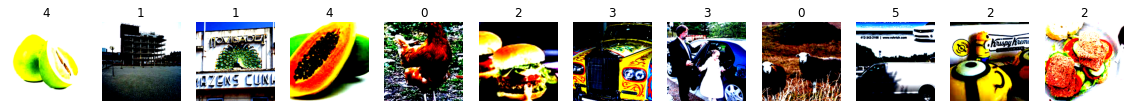

In [32]:
# Plot some test data
fig, axes = plt.subplots(figsize=(20,10), ncols = 12)
for image, label in train_loader:
    for i in range(12):
        img = image[i].swapaxes(0,1)
        img = img.swapaxes(1,2)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(label[i].item())
    break

In [47]:
# Load GoogLeNet pretrained model
googleNet = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

In [48]:
# Freeze all model parameters
for param in googleNet.parameters():
    param.requires_grad = False
# Add a few more layers of fully connect layer to adapt the output features to 6 instead of 1000
num_in_features = googleNet.fc.in_features
googleNet.fc = nn.Sequential(
    nn.Linear(in_features=num_in_features, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=6, bias=True)
)

In [49]:
# Enable CUDA device if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [45]:
# Move model to device
googleNet.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [46]:
# Method to conduct training with dropout
def train_model(dataloaders, model, criterion, optimizer, scheduler, has_dropout, dropout, num_epochs=25):
    # Check if gpu is available to train model
    use_gpu = torch.cuda.is_available()
    # Keep track of the best model weight
    best_model_wts = model.state_dict()
    # Keep track of the best accuracy
    best_acc = 0.0
    # Dataset size
    dataset_sizes = {'train': len(dataloaders['train'].dataset),
                     'valid': len(dataloaders['valid'].dataset)}
    # Start training
    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            # For train phase, model should set train property to be true, other phases (test, valid), model train property should be false
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
            
            # Record the running loss and correct
            running_loss = 0.0
            running_corrects = 0
            
            # Loop through data and process with model
            for inputs, labels in dataloaders[phase]:
                if use_gpu:
                    # For GPU training, copy data to device side
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    # Otherwise, keep data on host side
                    inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()
                
                # Forward propagation
                outputs = model(inputs)
                
                # Taken the largest output data as the predicted class
                _, preds = torch.max(outputs.data, 1)
                
                # Compute loss
                loss = criterion(outputs, labels)
                
                # For training phase, need to conduct back propagation
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # Record loss and correct
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
            # Get loss and accuracy
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
            
            # In case validation accuracy exceeds best so far, need to update recorded model
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()
            
        # Print training record for current epoch
        print('Epoch [{0}/{1}] train loss: {2:.4f} accuracy: {3:.4f}; valid loss: {4:.4f} accuracy: {5:.4f}'.format(epoch+1, num_epochs, train_epoch_loss, train_epoch_acc, valid_epoch_loss, valid_epoch_acc))
        
        # Check dropout
        if has_dropout and valid_epoch_acc >= dropout:
            print("Dropout accuracy achieved, breaking out from training loop")
            break
        
    # Record after all epochs
    print('Best accuracy: {0:.4f}'.format(best_acc))
    
    # Revert model to best model
    model.load_state_dict(best_model_wts)
    
    return model

In [50]:
# Set up loss layer and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googleNet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [51]:
# Define data loader
dataloaders = {'train': train_loader, 'valid': test_loader}

In [54]:
# Train model
start_time = time.time()
model = train_model(dataloaders, googleNet, criterion, optimizer, exp_lr_scheduler, True, 0.995, num_epochs=10)
print('Training time: {0} seconds'.format(time.time() - start_time))

# Save model
torch.save(model, "googlenet_trained.pth")

# Update googleNet with best model parameter
googleNet.load_state_dict(model.state_dict())

C:\Users\yzhan\AppData\Roaming\Python\Python39\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/10] train loss: 0.0300 accuracy: 0.1685; valid loss: 0.0296 accuracy: 0.1784
Epoch [2/10] train loss: 0.0295 accuracy: 0.3950; valid loss: 0.0288 accuracy: 0.6539
Epoch [3/10] train loss: 0.0281 accuracy: 0.6384; valid loss: 0.0264 accuracy: 0.6987
Epoch [4/10] train loss: 0.0235 accuracy: 0.6468; valid loss: 0.0188 accuracy: 0.6884
Epoch [5/10] train loss: 0.0149 accuracy: 0.7478; valid loss: 0.0111 accuracy: 0.8595
Epoch [6/10] train loss: 0.0097 accuracy: 0.8709; valid loss: 0.0080 accuracy: 0.9252
Epoch [7/10] train loss: 0.0073 accuracy: 0.9025; valid loss: 0.0059 accuracy: 0.9224
Epoch [8/10] train loss: 0.0061 accuracy: 0.9212; valid loss: 0.0057 accuracy: 0.9346
Epoch [9/10] train loss: 0.0059 accuracy: 0.9226; valid loss: 0.0055 accuracy: 0.9399
Epoch [10/10] train loss: 0.0056 accuracy: 0.9252; valid loss: 0.0054 accuracy: 0.9366
Best accuracy: 0.9399
Training time: 6230.657545566559 seconds


<All keys matched successfully>

In [55]:
# Train model
start_time = time.time()
model = train_model(dataloaders, googleNet, criterion, optimizer, exp_lr_scheduler, True, 0.995, num_epochs=10)
print('Training time: {0} seconds'.format(time.time() - start_time))

# Save model
torch.save(model, "googlenet_trained.pth")

# Update googleNet with best model parameter
googleNet.load_state_dict(model.state_dict())

Epoch [1/10] train loss: 0.0055 accuracy: 0.9245; valid loss: 0.0051 accuracy: 0.9360
Epoch [2/10] train loss: 0.0053 accuracy: 0.9284; valid loss: 0.0050 accuracy: 0.9377
Epoch [3/10] train loss: 0.0053 accuracy: 0.9298; valid loss: 0.0049 accuracy: 0.9388
Epoch [4/10] train loss: 0.0051 accuracy: 0.9268; valid loss: 0.0047 accuracy: 0.9424
Epoch [5/10] train loss: 0.0049 accuracy: 0.9308; valid loss: 0.0046 accuracy: 0.9399
Epoch [6/10] train loss: 0.0048 accuracy: 0.9302; valid loss: 0.0046 accuracy: 0.9405
Epoch [7/10] train loss: 0.0048 accuracy: 0.9293; valid loss: 0.0046 accuracy: 0.9441
Epoch [8/10] train loss: 0.0048 accuracy: 0.9304; valid loss: 0.0045 accuracy: 0.9413
Epoch [9/10] train loss: 0.0048 accuracy: 0.9300; valid loss: 0.0046 accuracy: 0.9421
Epoch [10/10] train loss: 0.0048 accuracy: 0.9328; valid loss: 0.0045 accuracy: 0.9405
Best accuracy: 0.9441
Training time: 6787.634794473648 seconds


<All keys matched successfully>

In [56]:
# Unfreeze all model parameters
for param in googleNet.parameters():
    param.requires_grad = True